In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDPMPipeline,DDPMScheduler
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms  
from tqdm.auto import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 从google ddpm仓库中导入模型
image_pipe = DDPMPipeline.from_pretrained(
    "./ddpm-celebahq-256"
)
image_pipe.to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.20.2",
  "_name_or_path": "./ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [4]:
# 使用DDIM管道替代DDPM管道
from diffusers import DDIMPipeline,DDIMScheduler

In [5]:
scheduler = DDIMScheduler.from_pretrained(
    "./ddpm-celebahq-256"
)
scheduler.set_timesteps(num_inference_steps=40)

In [6]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

In [7]:
image_pipe.scheduler = scheduler

### 接下来使用蝴蝶数据集实现微调

In [8]:
datasets = load_dataset(
    "./smithsonian_butterflies_subset/",
    split="train"
)

Repo card metadata block was not found. Setting CardData to empty.
HF google storage unreachable. Downloading and preparing it from source


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [18]:
# 定义小参数
batch_size = 4
image_size = 256
lr = 1e-5
num_epochs = 10
grad_accum = 2

In [12]:
# 定义预处理管道
preprocess = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

In [13]:
# 定义适用于训练集的预处理函数
def transform(example):
    images = [preprocess(image.convert("RGB")) for image in example["image"]]
    return {'images':images}

In [15]:
datasets.set_transform(transform)

In [16]:
# 储罐训练集加载器
train_loader = torch.utils.data.DataLoader(
    datasets,
    batch_size=batch_size,
    shuffle=True,
)

In [17]:
# 创建pytorch lightning模型
import pytorch_lightning as pl

In [24]:
class LightningModel(pl.LightningModule):
    def __init__(self,pipe):
        super().__init__()
        self.pipe = pipe.to(device)
        self.loss = None
        self.loss_method = nn.MSELoss()
        self.optimizer = torch.optim.AdamW(
            self.pipe.unet.parameters(),
            lr=lr
        )
        self.loss_metrics = []
    def training_step(self,batch,batch_idx):
        clean_images = batch["images"].to(device)
        # 随机噪声
        noise = torch.randn(clean_images.shape).to(device)
        # 获取batch_size
        batch_size = clean_images.shape[0]

        # 随机生成时间步
        time_steps = torch.randint(
            0,self.pipe.scheduler.num_train_timesteps,
            (batch_size,)
        ).to(device).long()
        # 生成噪声图像
        noisy_images = self.pipe.scheduler.add_noise(
            clean_images,noise,time_steps
        )
        # 生成预测
        noise_pred = self.pipe.unet(noisy_images,time_steps,return_dict=False)[0]
        # 计算损失
        self.loss = self.loss_method(noise_pred,noise)
        self.loss.backward(self.loss)
        # 记录损失
        self.loss_metrics.append(self.loss.item())
        self.optimizer.step()
        self.optimizer.zero_grad()
    def configure_optimizers(self):
        return self.optimizer
    def plot_loss(self):
        plt.plot(self.loss_metrics)
        plt.title("Loss")
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.show()

In [25]:
# 创建Trainer训练器对象
trainer = pl.Trainer(
    accumulate_grad_batches=grad_accum,
    max_epochs=num_epochs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [26]:
# 训练模型
model = LightningModel(image_pipe)
trainer.fit(model,train_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /root/Diffusers/chap5/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type    | Params
----------------------------------------
0 | loss_method | MSELoss | 0     
----------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
/root/anaconda3/envs/hugging/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider i

Training: 0it [00:00, ?it/s]

/root/anaconda3/envs/hugging/lib/python3.11/site-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/root/anaconda3/envs/hugging/lib/python3.11/site-packages/pytorch_lightning/loops/optimization/automatic.py:131: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")
`Trainer.fit` stopped: `max_epochs=10` reached.


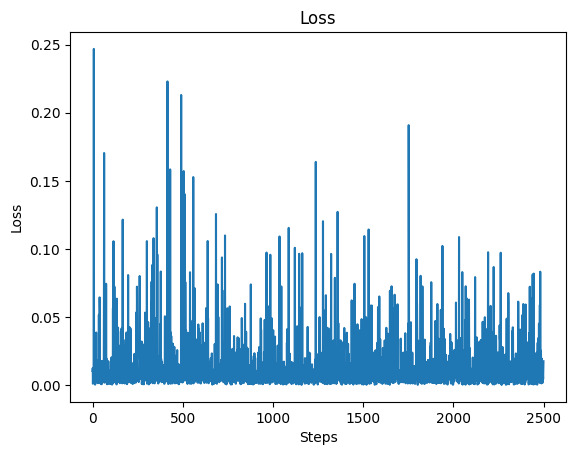

In [27]:
model.plot_loss()

0it [00:00, ?it/s]

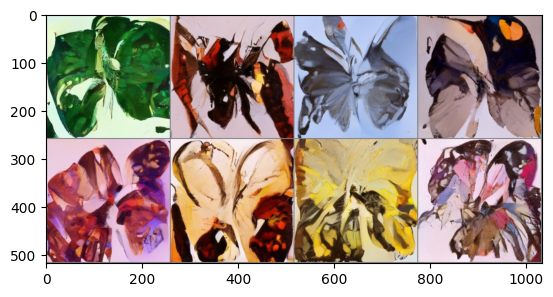

In [28]:
# 生成一些预测图像
x = torch.randn(8,3,256,256).to(device)
for i,t in tqdm(enumerate(model.pipe.scheduler.timesteps)):
    model_input = model.pipe.scheduler.scale_model_input(x,t)
    with torch.no_grad():
        pred = model.pipe.unet(model_input,t)["sample"]
    x = model.pipe.scheduler.step(pred,t,x).prev_sample

grid = torchvision.utils.make_grid(x,nrow=4)
plt.imshow(grid.permute(1,2,0).cpu().clip(-1,1) * 0.5 + 0.5)